**Utils for audio processing**

In [1]:
import numpy as np
import pandas as pd
import os
import re
import copy
import subprocess
import scipy.io.wavfile
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline  
import matplotlib


In [2]:
#Diretives 
AUDIO_PATH = 'test_wav/'
OUT_PATH = 'test_out/'
SH_FILE = 'goTests.sh'
SEG_SUFFIX = '.3.h.seg'

In [3]:
#read an audio file for experiments
sr,y = scipy.io.wavfile.read(filename='test_wav/diarizationExample.wav')

In [4]:
#calculate duration of the audio
def audio_duration(y,sr):
    return len(y)/sr

In [5]:
#get the number of frames
def get_nFrames(y,sr,winStep=0.010 ):
    num_frames = int(len(y)/(winStep*sr)) - 1    
    return num_frames


In [6]:
def Sample2sec(sample, sr):
    return sample/sr

In [7]:
def Sec2sample(sec, sr):
    return int(sec*sr)

In [8]:
def Frame2sec(frame, nframes, duration):
    return (frame*duration)/nframes

In [9]:
def Sec2Frame(sec, nframes, duration):
    return int((sec*nframes)/duration)

In [10]:
#function to run the LIUM spkdiar in an wav file, read the .h.3.seg file, identify the speaker segments, in seconds 
#and in frames and return this as a list

In [94]:
def runLIUMspkrdiar(data=AUDIO_PATH, sh=SH_FILE, out=OUT_PATH):
    with open(sh,mode='r+') as f:
        content = f.readlines()
        print(content)
        content[0] = 'inputfolder=./'+data+' \n'
        content[1] = 'outputfolder=./'+out+' \n'
        f.writelines(content)
        f.close()   

#command = "./openSMILE-2.1.0/inst/bin/SMILExtract -I {input_file} -C {conf_file} --csvoutput {output_file}".format(
#                                    input_file=wave_file,
#                                    conf_file=opensmile_conf,
#                                    output_file=features_file)
#output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)


    


In [11]:
filename = 'test_out/diarizationExample/diarizationExample.h.3.seg'
with open(filename) as f:
    diarfile = f.readlines()

In [12]:
diarfile

[';; cluster S0 \n',
 'diarizationExample 1 0 674 U U U S0\n',
 ';; cluster S1 \n',
 'diarizationExample 1 674 434 U U U S1\n',
 'diarizationExample 1 1586 301 U U U S1\n',
 'diarizationExample 1 2795 649 U U U S1\n',
 ';; cluster S2 \n',
 'diarizationExample 1 1108 478 U U U S2\n',
 'diarizationExample 1 1887 908 U U U S2\n',
 ';; cluster S6 \n',
 'diarizationExample 1 3444 753 U U U S6\n']

In [13]:
def findClusterPosition(diarfile):
    cluster_idx = []
    for i in range(len(diarfile)):
        aux_line = diarfile[i]
        if len([m.start() for m in re.finditer(';;', diarfile[i])])>0:
            cluster_idx.append(i)
    nclusters = len(cluster_idx)
    return cluster_idx, nclusters
        

In [14]:
findClusterPosition(diarfile)

([0, 2, 6, 9], 4)

In [129]:
diarfile


[';; cluster S0 \n',
 'diarizationExample 1 0 674 U U U S0\n',
 ';; cluster S1 \n',
 'diarizationExample 1 674 434 U U U S1\n',
 'diarizationExample 1 1586 301 U U U S1\n',
 'diarizationExample 1 2795 649 U U U S1\n',
 ';; cluster S2 \n',
 'diarizationExample 1 1108 478 U U U S2\n',
 'diarizationExample 1 1887 908 U U U S2\n',
 ';; cluster S6 \n',
 'diarizationExample 1 3444 753 U U U S6\n']

In [15]:
def FindSegments_Frame(diarfile, cluster_idx, nclusters):
    ClusterSegs = []
    for i in range(nclusters):
        if(i<(nclusters-1)):
            segsClus_i = diarfile[cluster_idx[i]+1:cluster_idx[i+1]]
        else:
            segsClus_i = diarfile[cluster_idx[i]+1:]
        SegsCluster_j = []
        for j in range(len(segsClus_i)):
            seg_j = segsClus_i[j]
            spaces = [m.start() for m in re.finditer(' ', seg_j)]
            fr_start = int(seg_j[(spaces[1]+1):spaces[2]])
            fr_end = int(seg_j[(spaces[2]+1):spaces[3]]) + fr_start
            SegsCluster_j.append([fr_start, fr_end])
        ClusterSegs.append(SegsCluster_j)
    return ClusterSegs

In [16]:
#teste
cluster_idx, nclusters = findClusterPosition(diarfile)
FindSegments_Frame(diarfile, cluster_idx, nclusters)

[[[0, 674]],
 [[674, 1108], [1586, 1887], [2795, 3444]],
 [[1108, 1586], [1887, 2795]],
 [[3444, 4197]]]

In [96]:
def FindSegments_Secs(Segments_Frame, nframes, duration):
    ClusterSegs = copy.deepcopy(Segments_Frame)
    for cluster_id,i in enumerate(Segments_Frame):
        for seg_id,j in enumerate(i):
            ClusterSegs[cluster_id][seg_id][0] = Frame2sec(j[0], nframes, duration)
            ClusterSegs[cluster_id][seg_id][1] = Frame2sec(j[1], nframes, duration)
    return ClusterSegs

In [97]:
#teste
Segments_Frame = []
duration = audio_duration(y,sr)
nframes = get_nFrames(y,sr,winStep=0.010)
cluster_idx, nclusters = findClusterPosition(diarfile)
Segments_Frame = FindSegments_Frame(diarfile, cluster_idx, nclusters)
FindSegments_Secs(Segments_Frame, nframes, duration)


[[[0, 674]], [[674, 1108], [1586, 1887], [2795, 3444]], [[1108, 1586], [1887, 2795]], [[3444, 4197]]]


[[[0.0, 6.742248272575649]],
 [[6.742248272575649, 11.083695973314272],
  [15.865290445556349, 18.87629449606862],
  [27.95932332618537, 34.45148820586133]],
 [[11.083695973314272, 15.865290445556349],
  [18.87629449606862, 27.95932332618537]],
 [[34.45148820586133, 41.984]]]

In [98]:
Segments_Frame

[[[0, 674]],
 [[674, 1108], [1586, 1887], [2795, 3444]],
 [[1108, 1586], [1887, 2795]],
 [[3444, 4197]]]

In [99]:
def FindSegments_Samples(Segments_Sec, sr):
    ClusterSegs = copy.deepcopy(Segments_Sec)
    for cluster_id,i in enumerate(Segments_Sec):
        for seg_id,j in enumerate(i):
            ClusterSegs[cluster_id][seg_id][0] = Sec2sample(j[0], sr)
            ClusterSegs[cluster_id][seg_id][1] = Sec2sample(j[1], sr)
    return ClusterSegs

In [100]:
#teste
Segments_Sec = FindSegments_Secs(Segments_Frame, nframes, duration)
FindSegments_Samples(Segments_Sec, sr)


[[[0, 107875]],
 [[107875, 177339], [253844, 302020], [447349, 551223]],
 [[177339, 253844], [302020, 447349]],
 [[551223, 671744]]]

In [155]:
#function to plot 
def plot_clusteredSignal(y, Segments_Sample):
    #plt.plot(y)  
    plt.axis([0,len(y),-33000,33000])
    x = np.linspace(0,len(y), num= len(y), dtype=int)
    colors = plt.cm.tab10(np.linspace(start=0, stop=10, dtype=int, num=len(Segments_Sample)))
    for clus_idx,i in enumerate(Segments_Sample):
        for seg_idx,j in enumerate(i): 
            print(j[0], j[1])            
            plt.plot(x[j[0]:j[1]], y[j[0]:j[1]], color = colors[clus_idx])
    plt.show()



0 107875
107875 177339
253844 302020
447349 551223
177339 253844
302020 447349
551223 671744


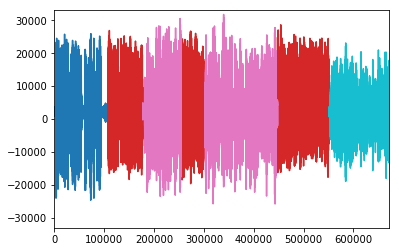

In [156]:
#teste
Segments_Sample = FindSegments_Samples(Segments_Sec, sr)
plot_clusteredSignal(y, Segments_Sample)

In [ ]:
#funtion to go through the audio signal of each segment and identify if it is voice or just silence with noise.

In [80]:
#Function to read the segments of each speaker and generate the segmented audio file
len(y) /sr

41.984

In [81]:
41.9*sr

670400.0

In [108]:
Segments_Sec

[[[0, 1079]],
 [[1079, 1773], [2539, 3021], [4474, 5514]],
 [[1773, 2539], [3021, 4474]],
 [[5514, 6719]]]

In [39]:
Segments_Frame, nframes, duration

([[[0.0, 6.748997591062609e-06]],
  [[6.748997591062609e-06, 1.1094791292132596e-05],
   [1.5881172373034563e-05, 1.8895190585066976e-05],
   [2.7987311968872385e-05, 3.44859758213941e-05]],
  [[1.1094791292132596e-05, 1.5881172373034563e-05],
   [1.8895190585066976e-05, 2.7987311968872385e-05]],
  [[3.44859758213941e-05, 4.202602802624594e-05]]],
 4197,
 41.984)

In [47]:
duration

41.984

In [48]:
nframes

4197

In [49]:
Segments_Frame

[[[0.0, 6.751248864979095e-08]],
 [[6.751248864979095e-08, 1.1098492199401833e-07],
  [1.5886469881093238e-07, 1.890149348399933e-07],
  [2.7996647741270867e-07, 3.4497479363483676e-07]],
 [[1.1098492199401833e-07, 1.5886469881093238e-07],
  [1.890149348399933e-07, 2.7996647741270867e-07]],
 [[3.4497479363483676e-07, 4.2040046715604235e-07]]]

In [114]:
colors

array([[ 0.12156863,  0.46666667,  0.70588235,  1.        ],
       [ 1.        ,  0.49803922,  0.05490196,  1.        ],
       [ 0.17254902,  0.62745098,  0.17254902,  1.        ],
       [ 0.83921569,  0.15294118,  0.15686275,  1.        ],
       [ 0.58039216,  0.40392157,  0.74117647,  1.        ],
       [ 0.54901961,  0.3372549 ,  0.29411765,  1.        ],
       [ 0.89019608,  0.46666667,  0.76078431,  1.        ],
       [ 0.49803922,  0.49803922,  0.49803922,  1.        ],
       [ 0.7372549 ,  0.74117647,  0.13333333,  1.        ],
       [ 0.09019608,  0.74509804,  0.81176471,  1.        ]])

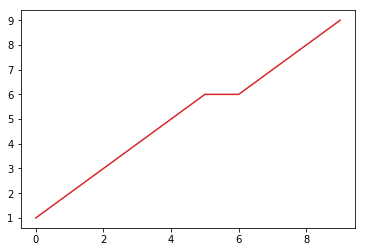

In [122]:
plt.plot([1,2,3,4,5,6,6,7,8,9], color = colors[3])

In [142]:
len(y)

671744

In [147]:
y


array([ 2077,  1911,  1836, ...,  6828,  1386, -1939], dtype=int16)

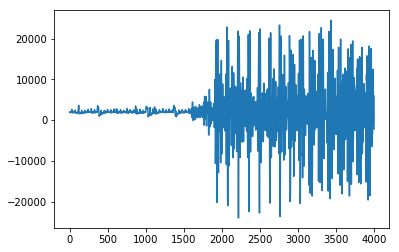

In [149]:
plt.plot(y[1000:5000])

array([     0,      1,      2, ..., 671741, 671742, 671744])